In [139]:
import pandas as pd
import numpy as np
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow'

In [140]:
df1 = pd.read_csv('./data/round-1-island-data-bottle/prices_round_1_day_-2.csv', delimiter = ";")
df2 = pd.read_csv('./data/round-1-island-data-bottle/prices_round_1_day_-1.csv', delimiter = ";")
df3 = pd.read_csv('./data/round-1-island-data-bottle/prices_round_1_day_0.csv', delimiter = ";")

In [141]:
df = pd.concat([df1, df2, df3])

In [142]:
def orderbook_preprocess(df):
    """
    对订单簿数据进行预处理
    1.填充NAN为0
    2.计算best_bid, best_ask, spread, mid_price, vwap, orderbook_imbalance, ask_bid_ratio
    """

    #填充orderbook数据,nan填为0
    columns = ['ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3']
    for column in columns:
        df[column] = df[column].fillna(0)
    
    #计算best_bid, best_ask, spread, mid_price, vwap
    df['best_bid'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].min(axis=1)
    df['best_ask'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].max(axis=1)

    #计算best_bid, best_ask

    def get_best_bid_ask_spread(row):
    # 获取有效的买价（去掉NaN） 计算最佳买价
        bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
        bid_prices = [price for price in bid_prices if price != 0]
        best_bid = min(bid_prices) if bid_prices else None

        # 获取有效的卖价（去掉NaN） 计算最佳卖价
        ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
        ask_prices = [price for price in ask_prices if price != 0]
        best_ask = max(ask_prices) if ask_prices else None
        
        # 计算价差
        spread = best_ask - best_bid
        return best_bid, best_ask, spread

    df[['best_bid', 'best_ask','spread']] = df.apply(get_best_bid_ask_spread, axis=1, result_type='expand')

    #计算mid_price 
    df['mid_price'] = (df['ask_price_1']+ df['bid_price_1']) / 2

    #计算vwap
    df['vwap'] = (df['ask_price_1']*df['ask_volume_1'] + df['ask_price_2']*df['ask_volume_2'] + df['ask_price_3']*df['ask_volume_3'] + df['bid_price_1']*df['bid_volume_1'] + df['bid_price_2']*df['bid_volume_2'] + df['bid_price_3']*df['bid_volume_3']) / (df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] + df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])
    
    #计算orderbook_imbalance
    def orderbook_imbalance(row):
        """ 计算订单簿不平衡度 """
        buy_orders = [(row['bid_price_1'], row['bid_volume_1']), (row['bid_price_2'], row['bid_volume_2']), (row['bid_price_3'], row['bid_volume_3'])]
        sell_orders = [(row['ask_price_1'], row['ask_volume_1']), (row['ask_price_2'], row['ask_volume_2']), (row['ask_price_3'], row['ask_volume_3'])]
        buy_pressure = sum(amount for price, amount in buy_orders if price != 0)
        sell_pressure = sum(amount for price, amount in sell_orders if price != 0)
        total_pressure = buy_pressure + sell_pressure
        if total_pressure == 0:
            return 0
        return (buy_pressure - sell_pressure) / total_pressure
    
    df['orderbook_imbalance'] = df.apply(orderbook_imbalance, axis=1)

    #计算ask_bid_ratio
    df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
    df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
    df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
    

    return df

In [143]:
df = orderbook_preprocess(df)

In [144]:
print(df.head())

   day  timestamp           product  bid_price_1  bid_volume_1  bid_price_2  \
0   -2          0  RAINFOREST_RESIN         9996             1       9995.0   
1   -2          0              KELP         1998            26          0.0   
2   -2          0         SQUID_INK         1998            26          0.0   
3   -2        100         SQUID_INK         1999             5       1998.0   
4   -2        100  RAINFOREST_RESIN        10000             5       9995.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  mid_price  \
0          25.0          0.0           0.0        10004  ...    10000.0   
1           0.0          0.0           0.0         2002  ...     2000.0   
2           0.0          0.0           0.0         2002  ...     2000.0   
3          26.0          0.0           0.0         2001  ...     2000.0   
4          20.0          0.0           0.0        10005  ...    10002.5   

   profit_and_loss  best_bid  best_ask  spread         vwap  \
0          

In [145]:
def extract_product_df(df, symbol: str):
    df_product = df[df['product'] == symbol]
    return df_product

In [146]:
df_kelp = extract_product_df(df, 'KELP')
df_resin = extract_product_df(df, 'RAINFOREST_RESIN')
df_ink = extract_product_df(df, 'SQUID_INK')

In [147]:
print(df_kelp.head())

    day  timestamp product  bid_price_1  bid_volume_1  bid_price_2  \
1    -2          0    KELP         1998            26          0.0   
5    -2        100    KELP         2000             5       1999.0   
6    -2        200    KELP         1999             1       1998.0   
10   -2        300    KELP         1999            27          0.0   
13   -2        400    KELP         1999            20          0.0   

    bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  mid_price  \
1            0.0          0.0           0.0         2002  ...     2000.0   
5            6.0       1998.0          20.0         2002  ...     2001.0   
6           30.0          0.0           0.0         2002  ...     2000.5   
10           0.0          0.0           0.0         2002  ...     2000.5   
13           0.0          0.0           0.0         2002  ...     2000.5   

    profit_and_loss  best_bid  best_ask  spread         vwap  \
1               0.0    1998.0    2002.0     4.0  2000.0000

<Axes: xlabel='mid_price', ylabel='Count'>

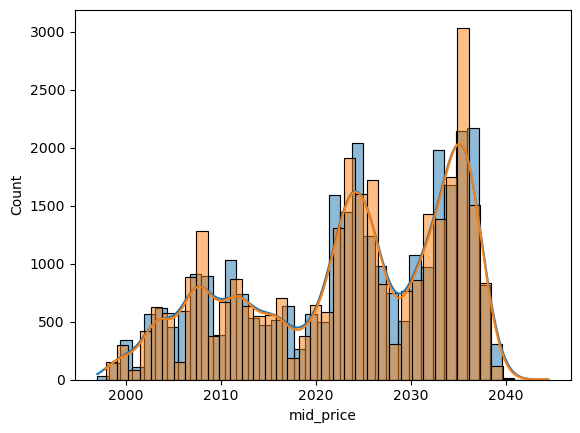

In [148]:
#可视化
import matplotlib.pyplot as plt
import seaborn as sns

#基本因子分布
columns = ['mid_price', 'vwap', 'spread', 'orderbook_imbalance', 'ask_bid_ratio']

sns.histplot(df_kelp['mid_price'], kde=True)
sns.histplot(df_kelp['vwap'], kde = True)


In [149]:
print(df_kelp['spread'].value_counts())

spread
3.0    17276
4.0    12724
Name: count, dtype: int64


count    30000.000000
mean         0.000060
std          0.061267
min         -0.636364
25%          0.000000
50%          0.000000
75%          0.015385
max          0.621622
Name: orderbook_imbalance, dtype: float64
Non zero ratio of orderbook imbalacne: 0.4992


<Axes: xlabel='orderbook_imbalance', ylabel='Count'>

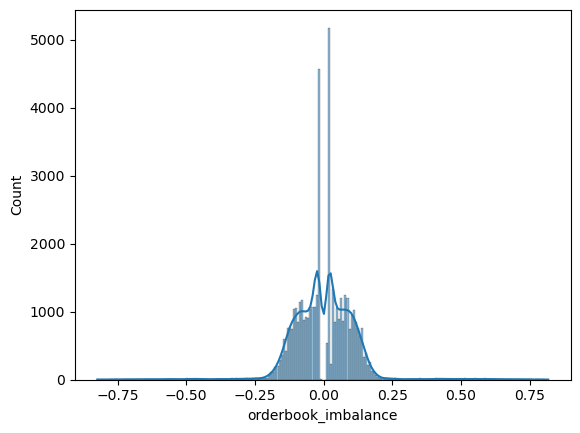

In [ ]:
print(df_kelp['orderbook_imbalance'].describe())

#计算0的个数和非0个数
zero_count = df_kelp['orderbook_imbalance'].value_counts().get(0, 0)
#计算非0的个数
non_zero_ratio = zero_count / len(df_kelp)
print(f'Non zero ratio of orderbook imbalance: {non_zero_ratio}')

df_kelp_filterd = df[df['orderbook_imbalance']!= 0]
sns.histplot(df_kelp_filterd['orderbook_imbalance'], kde = True)


count    30000.000000
mean        -0.000060
std          0.061267
min         -0.621622
25%         -0.015385
50%          0.000000
75%          0.000000
max          0.636364
Name: ask_bid_ratio, dtype: float64
Non zero ratio of ask bid ratio: 0.4992


<Axes: xlabel='ask_bid_ratio', ylabel='Count'>

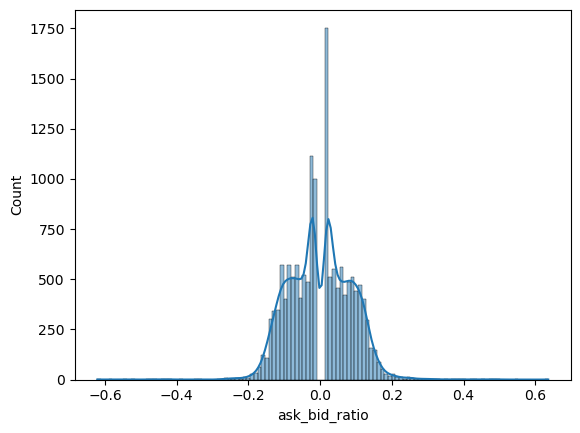

In [151]:
print(df_kelp['ask_bid_ratio'].describe())
#计算0的个数和非0个数
zero_count = df_kelp['ask_bid_ratio'].value_counts().get(0, 0)
#计算非0的个数
non_zero_ratio = zero_count / len(df_kelp)
print(f'Non zero ratio of ask bid ratio: {non_zero_ratio}')

df_kelp_filterd = df_kelp[df_kelp['ask_bid_ratio'] != 0]
sns.histplot(df_kelp_filterd['ask_bid_ratio'], kde = True)

In [152]:
import math
def fractional_derivative(ts, alpha, n_terms=10):
    """
    计算时间序列 ts 的分数阶导数
    参数:
        ts: 时间序列
        alpha: 阶数
        n_terms: 历史项的数量，控制内存长短

    返回:
        分数阶导数序列（长度与 ts 相同，前面一些值为 nan）
    """

    def binomial_coeff(a, k):
        return math.gamma(a + 1) / (math.gamma(k + 1) * math.gamma(a - k + 1))

    ts = np.asarray(ts)
    result = np.full_like(ts, np.nan, dtype=np.float64)

    for t in range(n_terms, len(ts)):
        val = 0.0
        for k in range(n_terms):
            coeff = (-1) ** k * binomial_coeff(alpha, k)
            val += coeff * ts[t - k]
        result[t] = val
    return result

def rolling_window(ts, window_length: int):
    ts_diff = ts.diff(window_length)
    ts_vol = ts.rolling(window_length).std()
    ts_mean = ts.rolling(window_length).mean()
    ts_zscore = (ts - ts_mean) / ts_vol
    return ts_diff, ts_vol, ts_mean, ts_zscore


In [161]:
from scipy.stats import kurtosis

def get_return(df):
    df = df.copy()
    df['mid_price_diff_5'] = df['mid_price'] - df['mid_price'].shift(5)
    df['log_return_5'] = np.log(df['mid_price']).diff(5)
    df.dropna(inplace=True)
    k = kurtosis(df['log_return_5'])
    print("Kurtosis of log_return_5: ", k)
    return df

In [162]:
df_kelp = get_return(df_kelp)

Kurtosis of log_return_5:  1.8750666843239419


In [163]:
print(df_kelp.head())
print(df_kelp['log_return_5'].describe())

    day  timestamp product  bid_price_1  bid_volume_1  bid_price_2  \
45   -2       1500    KELP         1999            27          0.0   
49   -2       1600    KELP         1999            24          0.0   
52   -2       1700    KELP         1999            28          0.0   
54   -2       1800    KELP         1999            24          0.0   
57   -2       1900    KELP         2001             1       1999.0   

    bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  best_bid  \
45           0.0          0.0           0.0         2002  ...    1999.0   
49           0.0          0.0           0.0         2002  ...    1999.0   
52           0.0          0.0           0.0         2001  ...    1999.0   
54           0.0          0.0           0.0         2001  ...    1999.0   
57          26.0          0.0           0.0         2002  ...    1999.0   

    best_ask  spread         vwap  orderbook_imbalance  ask_volume  \
45    2002.0     3.0  2000.500000             0.000000    

In [ ]:
#kelp的mid_price_diff
from scipy.stats import norm


Kurtosis of log_return:  nan
Kurtosis of log_return:  nan
Kurtosis of log_return:  nan


/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_35223/2208456302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid_price_diff_5'] = df['mid_price'] - df['mid_price'].shift(5)
/opt/anaconda3/envs/quant/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/n2/td6lyvzx2pd6703265_bhdl80000gn/T/ipykernel_35223/2208456302.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [164]:
df_ink = get_return(df_ink)
print(df_ink.head())

Kurtosis of log_return_5:  96.19146451448705
    day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
15   -2        500  SQUID_INK         1999             1       1997.0   
19   -2        600  SQUID_INK         1997            30          0.0   
23   -2        700  SQUID_INK         1999            28          0.0   
26   -2        800  SQUID_INK         2002             1       1999.0   
27   -2        900  SQUID_INK         1999             2       1998.0   

    bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ...  best_bid  \
15          30.0          0.0           0.0         2000  ...    1997.0   
19           0.0          0.0           0.0         2001  ...    1997.0   
23           0.0          0.0           0.0         2002  ...    1999.0   
26          23.0          0.0           0.0         2003  ...    1999.0   
27          30.0          0.0           0.0         2001  ...    1998.0   

    best_ask  spread         vwap  orderbook_imbalance  ask_volum

<Axes: xlabel='mid_price_diff', ylabel='Count'>

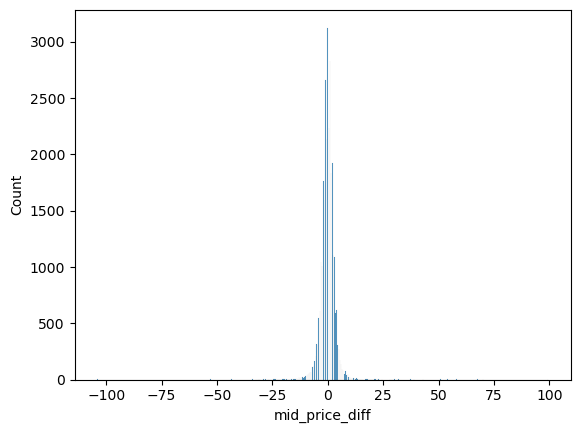

In [ ]:
sns.histplot(df_ink['mid_price_diff'])

In [167]:
print(df_ink['log_return_5'])

15      -0.000250
19      -0.000500
23       0.001000
26       0.002000
27       0.001001
           ...   
29986   -0.000546
29989    0.000819
29993    0.001637
29994    0.002997
29998    0.004905
Name: log_return_5, Length: 29995, dtype: float64


In [171]:
def IC_IR(df, factor_column: str, return_column: str, risk_free_rate: float):
    """
    Calculate the Information Coefficient (IC) and Implied Risk-Free Rate (IRR) of a factor using the CAPM model.
    :param df: DataFrame with columns for the factor, return, and market return.
    :param factor_column: Name of the column containing the factor values.
    :param return_column: Name of the column containing the return values.
    :param risk_free_rate: Risk-free rate used in the CAPM model.
    :return: Tuple of the IC and IRR values.
    """
    # Calculate the market return
    market_return = df[return_column].mean()
    # Calculate the CAPM beta
    beta = (df[return_column] - risk_free_rate - df[factor_column] * market_return) / (df[factor_column] ** 2)

    # Calculate the CAPM alpha
    alpha = market_return - risk_free_rate - beta * df[factor_column]

    # Calculate the Information Coefficient (IC)
    ic = (beta ** 2) / (1 - beta ** 2)

    # Calculate the Implied Risk-Free Rate (IRR)
    irr = (1 + alpha) / (1 + beta)
    return ic, irr


In [176]:
df_ink['kurt_50'] = df_ink['log_return_5'].rolling(50).apply(kurtosis)
df_ink.dropna(inplace=True)
ic, irr = IC_IR(df_ink, 'log_return_5', 'kurt_50', 0)
#print(ic, irr)


In [ ]:
print(ic.describe())
sns.histplot(ic, kde=False)

count    26778.000000
mean        -1.000000
std          0.000036
min         -1.005501
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         -1.000000
dtype: float64


In [ ]:
def calculate_factors(df):
    """
    计算因子：
    订单簿因子：orderbook_imbalance, ask_bid_ratio（已实现）
    基本因子：对数收益率（5）， 波动率（10）
    肥尾因子：kurt(50)
    衍生因子：上述的1阶差分和1/2阶差分
    """
    df['log_return5'] = np.log(df['mid_price']).diff(5)
    df['vol10'] = df['mid_price'].rolling(10).std()
    df['kurt50'] = df['log_return_5'].rolling(10).kurt()
    df['orderbook_imbalance_5_1/2'] = fractional_derivative(df['orderbook_imbalance'], 1/2, 5)
    df['orderbook_imbalance_5_1'] = fractional_derivative(df['orderbook_imbalance'], 1, 5)
    df['ask_bid_ratio_5_1/2'] = fractional_derivative(df['ask_bid_ratio'], 1/2, 5)
    df['ask_bid_ratio_5_1'] = fractional_derivative(df['ask_bid_ratio'], 1, 5)
    df['vol10_5_1/2'] = fractional_derivative(df['vol10'], 0.5, 5)
    df['vol10_5_1'] = fractional_derivative(df['vol10'], 1, 5)
    df['kurt50_5_1/2'] = fractional_derivative(df['kurt50'], 0.5, 5)
    df['kurt_50_1'] = fractional_derivative(df['kurt50'], 1, 5)
    return df

In [2]:
df_kelp = calculate_factors(df_kelp)

NameError: name 'df_kelp' is not defined